In [2]:
%%capture
%matplotlib inline
#Block output of installs and determine plot output 

#Install and upgrade relevant libraries
!pip install seaborn yahooquery PyPDF2 --upgrade                                            

#Import all relevant libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
import numpy as np
from PyPDF2 import PdfReader
import os
from datetime import date as dt
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

#Block warnings and set displayed dataframe settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)                                                        
pd.set_option('max_colwidth', 1000)                                                            

In [152]:
#INTERACTIONS AND ARTICLES PUBLISHED PER MONTH FOR THESE KEYWORDS: CSR, CLIMATE CHANGE, ESG, GLOBAL WARMING, GREENHOUSE GAS, NDC, POLLUTION, SDG

#Import data
mon_2014 = pd.read_excel("Source_Data/Monthly_KW/2014.xlsx",header=0)
mon_2015 = pd.read_excel("Source_Data/Monthly_KW/2015.xlsx",header=0)
mon_2016 = pd.read_excel("Source_Data/Monthly_KW/2016.xlsx",header=0)
mon_2017 = pd.read_excel("Source_Data/Monthly_KW/2017.xlsx",header=0)
mon_2018 = pd.read_excel("Source_Data/Monthly_KW/2018.xlsx",header=0)
mon_2019 = pd.read_excel("Source_Data/Monthly_KW/2019.xlsx",header=0)
mon_2020 = pd.read_excel("Source_Data/Monthly_KW/2020.xlsx",header=0)
mon_2021 = pd.read_excel("Source_Data/Monthly_KW/2021.xlsx",header=0)
mon_2022 = pd.read_excel("Source_Data/Monthly_KW/2022.xlsx",header=0)
mon_2023 = pd.read_excel("Source_Data/Monthly_KW/2023.xlsx",header=0)

#Define data wrangling function
def wrangle(df):

    #Drops columns
    df.drop(['Link','Authors','Pinterest','LinkedIn','Twitter Influencer Shares','Total Facebook','Likes','Shares','Comments'],axis=1,inplace=True)

    #Converts published column to datetime format and converts article title to lowercase
    df['Published'] = df['Published'].apply(lambda x: x[0:4] + '-' + x[5:7])
    df['Headline'] = df['Headline'].str.lower()
    
    #Renames and reorders columns
    df.rename(columns={'Published':'Date','Group':'Keyword','Headline':'Title','Total Interactions':'Interactions'},inplace=True)
    df = df.reindex(columns=['Date','Keyword','Title','Website','Interactions'])

    return df

#Categorizes keywords to increase visibility and isolate CSR
def kw_categorize(keyword):
    if keyword in ['Climate Change','Global Warming','Greenhouse gas','Pollution']:
        return 'Climate'
    elif keyword == 'CSR':
        return 'CSR'
    elif keyword in ['ESG','NDC','SDG']:
        return 'Sustainability (ESG, NDC, SDG)'

#Concatenates wrangled data
mon_kw = pd.concat([wrangle(mon_2014),wrangle(mon_2015),wrangle(mon_2016),wrangle(mon_2017),wrangle(mon_2018),wrangle(mon_2019),wrangle(mon_2020),wrangle(mon_2021),\
                    wrangle(mon_2022),wrangle(mon_2023)],axis=0,ignore_index=True)

#Runs the categorize function on the keyword column and appends a new column containing the category
mon_kw['Keyword Category'] = mon_kw['Keyword'].apply(kw_categorize)

#Reorder columns
mon_kw = mon_kw.reindex(columns=['Date','Keyword','Keyword Category','Title','Website','Interactions'])

In [235]:
#FUNCTION FOR DUAL AXIS LINEGRAPH

#Input parameters are dataframe, seaborn style, x axis, left y axis, colour for left y value, right y axis, colour for right y value
def dual_lines(df,style,x,y1,colour1,y2,colour2):

    #Set figure size and style
    plt.figure(figsize=(10,6))
    sns.set_style(style)

    #Define artist layer for left y axis and places legend in top right
    ax1 = sns.lineplot(data=df,x=x,y=y1,label=y1,color=colour1)
    plt.legend(loc='upper right',bbox_to_anchor=(0.866,0.98),alignment='left')

    #Define second plot on the same figure as a lineplot for right y axis and sharing the same x axis
    ax2 = plt.twinx()
    ax2 = sns.lineplot(data=df,x=x,y=y2,label=y2,color=colour2)

    #Legend is adjusted to be just under the first legend
    plt.legend(loc='upper right',bbox_to_anchor=(0.9,0.925),alignment='left')

    #Set x ticks to be evenly spaced values across all available x values
    ax2.set_xticks(df[x].tolist()[0::11])

    #Adjusts labels for all axes
    ax1.set_xlabel(x,fontweight='bold')
    ax1.set_ylabel(y1,fontweight='bold')
    ax2.set_ylabel(y2,fontweight='bold',rotation=270,labelpad=13)
    
    return plt.show()

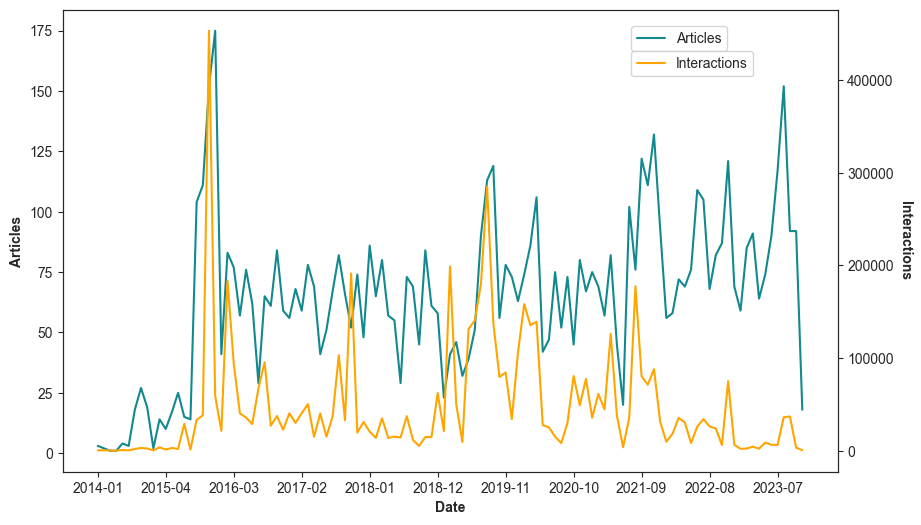

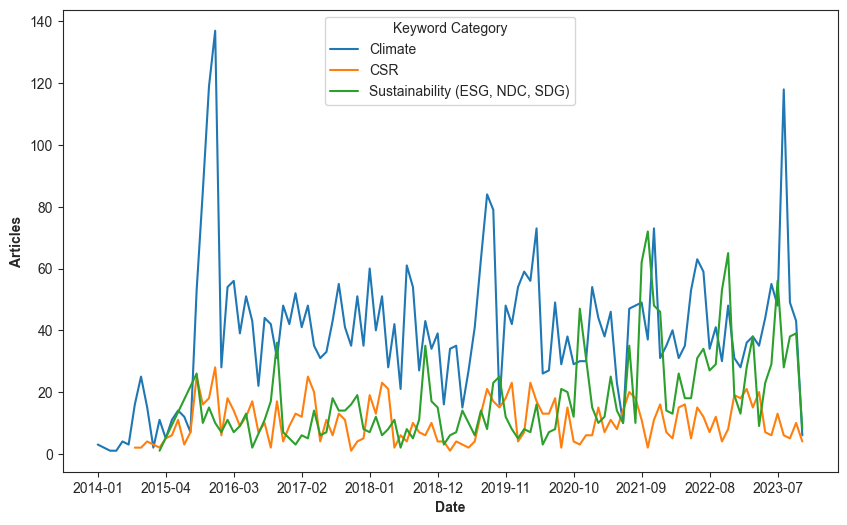

In [245]:
#LINEGRAPH - ARTICLES VS INTERACTIONS FOR ALL KEYWORDS
#Groupby Date, count number of keyword articles, and sums interactions then resets index
forviz = mon_kw[['Date','Keyword','Interactions']].groupby(['Date']).agg({'Keyword':'count','Interactions':'sum'}).rename(columns={'Keyword':'Articles'})
forviz.reset_index(inplace=True)
articles_vs_interactions = dual_lines(forviz,'ticks','Date','Articles','#11898E','Interactions','orange')

#LINEGRAPH - NUMBER OF ARTICLES SPLIT BY KEYWORD
#Groupby Date and Keyword Category, counts each, renames the column then resets index
keywordz = mon_kw[['Date','Keyword Category','Title']].groupby(['Date','Keyword Category']).count().rename(columns={'Title':'Articles'})
keywordz.reset_index(inplace=True)

#Sets figure size and style
plt.figure(figsize=(10,6))
sns.set_style('ticks')

#Plots linegraph with Date on the x-axis, Articles on the y-axis, keyword categories distinguished by color, and sets the x ticks to be evenly spaced across all months
sns.lineplot(data=keywordz,x='Date',y='Articles',hue='Keyword Category').set_xticks(forviz['Date'].tolist()[0::11])
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Articles',fontweight='bold')
plt.show()

In [78]:
#REVENUE PER SHARE VS TOTAL ESG SCORE FROM YAHOO FINANCE

#Imports tickers of top 50 largest companies in Indonesia by market cap into a dataframe. '.JK' is appended to each name as this is the format found on Yahoo Finance
df1 = pd.DataFrame({'Tickers':[x+'.JK' for x in\
                    list(pd.read_excel("Source_Data/Indo_50_Biggest_Companies.xlsx",sheet_name="50 Biggest Market Capitalizatio",header=3,nrows=51,usecols=[2])['Code'])[1:]]})

#Define function to fetch all ticker data
def fetch_data_for_ticker(ticker):
    
    #Define function of pulling data from Yahoo Finance using tickers. Datatype specifies which data to pull from Yahoo Finance
    def yahoodata(row,datatype):
        #Define try block which will return None if no data available for that ticker
        try:
            #Returns the relevant financial data based on datatype and ticker
            x = Ticker(str(row))
            if datatype == 'revenuePerShare' or datatype == 'currentPrice':
                return x.financial_data[str(row)][datatype]
            elif datatype == 'totalEsg':
                return x.esg_scores[str(row)][datatype]
        except:
            return np.nan

    #Returns a tuple with all requested data
    return tuple([str(ticker)] + [yahoodata(ticker,'currentPrice')] + [yahoodata(ticker,'revenuePerShare')] + [yahoodata(ticker,'totalEsg')])

#Returns a tuple of called data for each ticker in df1. Uses multi-threading with 10 simultaneous workers to speed up query
with ThreadPoolExecutor(max_workers=10) as executor:
   results = executor.map(fetch_data_for_ticker,df1['Tickers'])

#Unpacks the tuples into 4 distinct variables and assigns these to the relevant columns in df1
for result in results:
    ticker, current_price, revenue_per_share, total_esg = result
    df1.loc[df1['Tickers'] == ticker,'Current Share Price'] = current_price
    df1.loc[df1['Tickers'] == ticker,'Revenue per Share'] = revenue_per_share
    df1.loc[df1['Tickers'] == ticker,'Total ESG Rating'] = total_esg

In [129]:
#FUNCTION FOR EXTRACTING COMPANY REVENUE

#Define function to extract data
def revenue(companyname,revenuepage):

    #Navigates to local directory. Folder name must be exactly same as companyname parameter
    directory = '.\\Source_data\\Companies\\' + companyname

    #Initialise empty month and revenue lists
    month = []
    revenue = []

    #Loops through each file in the directory
    for filename in os.listdir(directory):

        #Monthly files are named in this format: BCA_2018_01.pdf
        #Extracts year and month from the filename and appends it to the month list
        month.append(str(filename[len(companyname)+1:len(companyname)+5]) + '-' + str(filename[len(companyname)+6:len(companyname)+8]))

        #Creates a PDF reader object using the directory and file name
        reader = PdfReader(os.path.join(directory,filename))

        #Returns the position of the first instance of 'Pendapatan Bunga' among all the text of the specified revenue page
        pos = reader.pages[revenuepage].extract_text().find('Pendapatan Bunga')

        #Revenue data is found in a set distance away from the position of 'Pendapatan Bunga'
        rev_data = reader.pages[revenuepage].extract_text()[pos+16:pos+28]

        #Removes the . from the revenue data, removes white spaces, converts to an integer then appends to the revenue list
        revenue.append(int(rev_data.strip().replace('.','')))

    #Creates a dataframe with the dates and cumulative interest (the extracted revenue is cumulative over the months)
    df = pd.DataFrame({'Date':month,'Cumulative Interest':revenue})

    #Converts to monthly interest by subtracting each value by the previous month
    df['Monthly Interest'] = df['Cumulative Interest'] - df['Cumulative Interest'].shift(fill_value=0)

    #The first month of every year ends up negative because of subtracting by the entire year's data so converts each negative to the month's value
    df.loc[df['Monthly Interest'] < 0,'Monthly Interest'] = df.loc[df['Monthly Interest'] < 0,'Cumulative Interest']

    return df

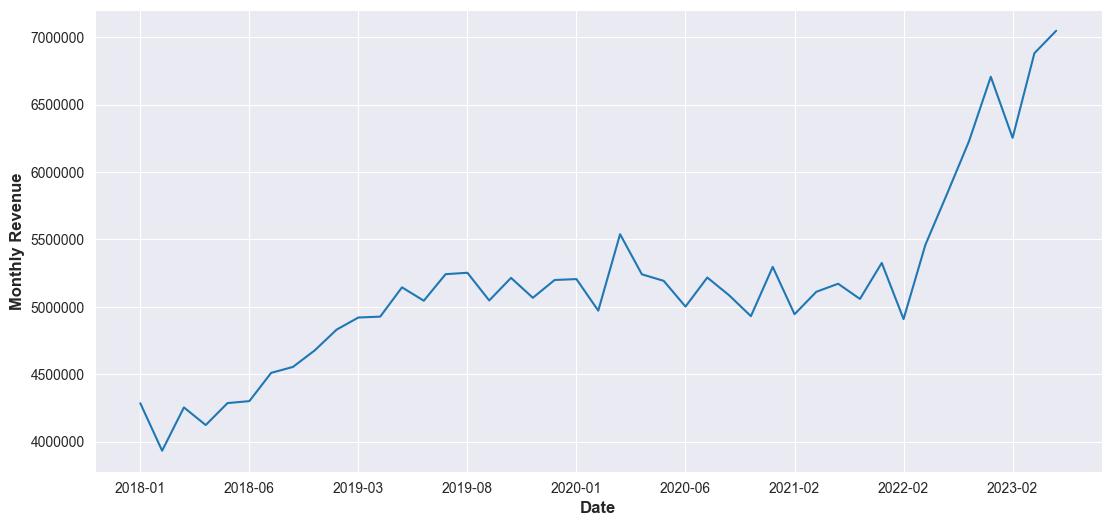

In [165]:
#BCA - UNCOMMENT CHART CODE TO SEE PLOT

#Calls the revenue function on the BCA data and drops outliers using the interquartile range
BCA = revenue('BCA',revenuepage=2)
Q3 = BCA['Monthly Interest'].quantile(0.75)
Q1 = BCA['Monthly Interest'].quantile(0.25)
IQR = Q3 - Q1
BCA = BCA.loc[BCA['Monthly Interest'] <= (Q3+1.5*IQR)]

#Set figure size and style
plt.figure(figsize=(13,6))
sns.set_style('darkgrid',{'axes.grid':True})

#Defines lineplot in the artist layer
ax = sns.lineplot(data=BCA,x='Date',y='Monthly Interest')

#Sets the x ticks as evenly spaced across available dates
ax.set_xticks([BCA['Date'].tolist()[x] for x in list(range(0,43,5))])

#Adjusts the y axis to plain so as not to use scientific notation
ax.ticklabel_format(axis='y',style='plain')

#Sets and formats labels
plt.xlabel('Date',fontweight='bold',fontsize=12)
plt.ylabel('Monthly Revenue',fontweight='bold',fontsize=12)
plt.show()

In [176]:
data_2018 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2018.xlsx",header=0)
data_2019 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2019.xlsx",header=0)
data_2020 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2020.xlsx",header=0)
data_2021 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2021.xlsx",header=0)
data_2022 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2022.xlsx",header=0)
data_2023 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2023.xlsx",header=0)

comp_esg = pd.concat([wrangle(data_2018),wrangle(data_2019),wrangle(data_2020),wrangle(data_2021),wrangle(data_2022),wrangle(data_2023)],axis=0,ignore_index=True)

BCA_articles = comp_esg.loc[comp_esg['Keyword'] == 'BCA',['Date','Title','Interactions']].groupby('Date').agg({'Title':'count','Interactions':'sum'})
BCA_articles.reset_index(inplace=True)

#plt.figure(figsize=(10,6))
#sns.set_style('dark')
#sns.lineplot(data=BCA_articles,x='Date',y='Number of Articles',color='#930B0B')

BCA_articles

,Date,Title,Interactions
0,2018-02,1,0
1,2018-04,1,0
2,2018-05,2,2
3,2018-07,1,0
4,2018-11,5,0
5,2019-03,2,2
6,2019-04,2,2
7,2019-05,5,3
8,2019-07,21,101
9,2019-09,1,0
